# Analysis of the clusters

So the time is here to do some analysis.   
Here dataset already has detected clusters and calculated Location Quotient. 

In [1]:
#general
import numpy as np
import scipy
from matplotlib import pyplot as plt
%pylab inline
import pandas as pd
import MySQLdb
import os
import sys
sys.setrecursionlimit(3000)

Populating the interactive namespace from numpy and matplotlib


In [4]:
con=MySQLdb.connect(user=user, passwd=passwd, db=dbname, host=host)
df = pd.read_sql("SELECT * FROM business WHERE state ='AZ' ", con)
print "data loaded"

data loaded


The low activity of some businesses in their particular cluster caused their Location Quotient to be marked as inf because of the computing roundup. <br>
The trick is with the LQ equation. Here you can see the equation again. <br>



$$LQ_{ij}=\frac{\frac{E_{ij}}{E_i}}{\frac{\sum_i E_{ij}}{\sum_i E_i}}$$
Where   
$E_{ij}$ is economic activity in subarea i, department j  
$E_i$ is total economic activity in subarea i   
$\sum_i E_{ij}$ is economic activity of department j in the whole area    
$\sum_i E_i$ is total economic activity in the whole area

So when a business has low activity, the real value of nominator is of an order of $10^{-6}$.  That is small enough number that my computer decides that the value is so close to the zero and thus can be zero; causing division to produce infinity. This creates a problem to me since, in reality, those businesses are not the most popular, they are the least popular in the cluster.  <br>
Therefore, I decided to replace all infinity values with the minimum value of Location Quotient. Yes, this will assign a higher value of LQ to those unpopular businesses, but in clusters that have more than four business each, such low visited businesses do not even come into future calculations. 

In [7]:
i=0
for t in df.LQ:
    if t == np.inf:
        df.LQ.loc[i]=df.LQ.min()
    i=i+1

/Users/Lexa/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Let us see individual cluster.

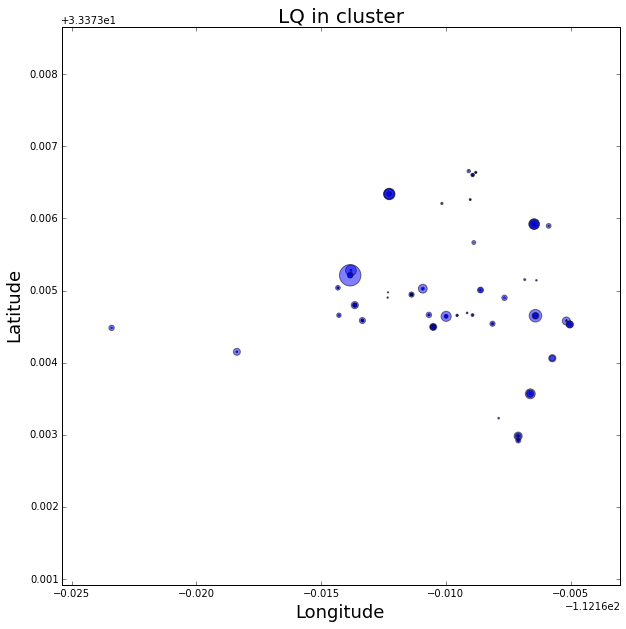

In [9]:
lqCluster=df[df.cluster ==1]
plt.figure(figsize=(10, 10), dpi=100)
df_scatter = plt.scatter(lqCluster['longitude'], lqCluster['latitude'], c='b', alpha=.5, s=lqCluster['LQ']*10)
plt.title( 'LQ in cluster', fontsize=20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize =18)
plt.xlim(lqCluster.longitude.min()-0.002,lqCluster.longitude.max()+0.002)
plt.ylim(lqCluster.latitude.min()-0.002,lqCluster.latitude.max()+0.002)
plt.show()

## Determining the buis. enviroment


Now is time to determine which businesses are carrying economic activity in each cluster. <br>
I also wish to see how those categories relate to the most common category of the cluster. 

In [4]:
df2=pd.DataFrame(df.cluster.unique())
df2['BusNum']=0
df2['topBusCat']=''
df2['topCatNum']=0
df2['LQmax']=0
df2['cat1']=''
df2['cat1num']=0
df2['cat2']=''
df2['cat2num']=0
df2['cat3']=''
df2['cat3num']=0
df2 = df2.rename(columns={0: 'cluster'})

Now, it is time to populate this table. <br>
So, I am picking top business as the business that has the highest LQ in the cluster. Then, for other three categories I am counting business for each type of business, sorting them in descending order and put into the table the top 3. <br>
Of course, in my cluster classification I have clusters that have less than four business together. In that case, all remaining business are sorted accordingly.

In [8]:
import operator
for c in df.cluster.unique():
    pom = df[df.cluster == c]
    large = pom.LQ.max()
    topBus = pom.name.ix[pom.LQ == large].values[0]
    topBusCat = pom.categories.ix[(pom.name == topBus) & (pom.LQ == large)].values[0]
    df2.topBusCat.loc[df2.cluster == c] = topBusCat
    df2.LQmax.loc[df2.cluster == c]=large
    bNum=pom.name.unique()
    df2.BusNum.loc[df2.cluster == c]=len(bNum)
    topCatStart=[]
    topCat = getTopCategories(topBusCat, topCatStart, pom)
    topCatNum =pom.name[pom.categories == topBusCat].count()
    df2.topCatNum.loc[df2.cluster ==c]=topCatNum
    cat = pom.categories.unique()
    Rcat = cat[np.argwhere(np.in1d(cat,np.intersect1d(cat,topCat))==False)]
    if len(Rcat)>0:
        sortedBusR = SortingBusinessCategories(Rcat,pom)
        first = sortedBusR[0]
        df2.cat1.loc[df2.cluster == c] = first[0]
        df2.cat1num.loc[df2.cluster == c] = first[1].astype(int)
        topCate = getTopCategories(first[0],topCat,pom)
        Rcat = cat[np.argwhere(np.in1d(cat,np.intersect1d(cat,topCate))==False)]
        if len(Rcat)>0:
            sortedBusR = SortingBusinessCategories(Rcat,pom)
            second = sortedBusR[0]
            df2.cat2.loc[df2.cluster == c] = second[0]
            df2.cat2num.loc[df2.cluster == c] = second[1].astype(int)
            topCateg = getTopCategories(second[0],topCate,pom)
            Rcat = cat[np.argwhere(np.in1d(cat,np.intersect1d(cat,topCateg))==False)]
            if len(Rcat)>0:
                sortedBusR = SortingBusinessCategories(Rcat,pom)
                third = sortedBusR[0]
                df2.cat3.loc[df2.cluster == c] = third[0]
                df2.cat3num.loc[df2.cluster == c] = third[1].astype(int)



And resulting table looks like:

In [9]:
df2.head(5)

,cluster,BusNum,topBusCat,topCatNum,LQmax,cat1,cat1num,cat2,cat2num,cat3,cat3num
0,3,8637,Beer Bar,1,1.770652,Shopping,1691,Mexican,495,Pizza,303
1,0,853,Fireplace Services,1,39.935685,Restaurants,271,Shopping,129,Automotive,88
2,828,1,Apartments,1,415.353912,,0,,0,,0
3,919,1,Golf,1,523.512327,,0,,0,,0
4,18,995,Ski Resorts,1,21.027324,Restaurants,269,Beauty & Spas,94,Home Services,80


In next step I'll use:


##Kendall tau rank correlation coefficient

In statistics, the Kendall rank correlation coefficient, commonly referred to as Kendall's tau ($\tau$) coefficient, is a statistic used to measure the association between two measured quantities. A tau test is a non-parametric hypothesis test for statistical dependence based on the tau coefficient.    

It is a measure of rank correlation: the similarity of the orderings of the data when ranked by each of the quantities.   

Let $(x_1, y_1), (x_2, y_2)$, …, $(x_n, y_n)$ be a set of observations of the joint random variables X and Y respectively, such that all the values of $(x_i)$ and $(y_i)$ are unique. Any pair of observations $(x_i, y_i)$ and $(x_j, y_j)$ are said to be concordant if the ranks for both elements agree: that is, if both $x_i > x_j$ and $y_i > y_j$ or if both $x_i < x_j$ and $y_i < y_j$. They are said to be discordant, if $x_i > x_j$ and $y_i < y_j$ or if $x_i < x_j$ and $y_i > y_j$. If $x_i = x_j$ or $y_i = y_j$, the pair is neither concordant nor discordant.

The Kendall $\tau$ coefficient is defined as:

$$\tau = \frac{(\text{number of concordant pairs}) - (\text{number of discordant pairs})}{\frac{1}{2} n (n-1) }$$

The coefficient range is $−1 ≤ \tau ≤ 1$.

-If the agreement between the two rankings is perfect (i.e., the two rankings are the same) the coefficient has value 1.   
-If the disagreement between the two rankings is perfect (i.e., one ranking is the reverse of the other) the coefficient has value −1.   
-If X and Y are independent, then we would expect the coefficient to be approximately zero.   

To get a decent sample, only business categories that existed in more than 4 cluster are taken into consideration. For each of them Kendall Tau coefficient is calculated. 

In [12]:
from scipy.stats import kendalltau
topCategories = df2.topBusCat.unique()
Tbus = {}
for rc in topCategories:
    Tbus.update({rc: df2.cluster[df2.topBusCat == rc].count()})
sortedCat = sorted(Tbus.items(), key=operator.itemgetter(1), reverse=True)
cou=0.
for s in sortedCat:
    if s[1]>4:
        df3=df2[df2.topBusCat == s[0]]
        result=df3.LQmax.tolist()
        parameter = df3.cat1.tolist()
        cou+=1.
        KT = kendalltau(parameter, result)
        sida=1.-(1.-KT[1])**cou #make Sidak correction.
        if sida<0.1:
            print s[0], KT[0], KT[1], 'Sidak correction:', sida
        #print s[0], KT[0], KT[1]

Golf -0.621069137264 1.8017368295e-09 Sidak correction: 1.80173687081e-09
Horseback Riding -0.567961834247 0.00466260929476 Sidak correction: 0.00930347866408
Heating & Air Conditioning/HVAC -1.0 6.30004526164e-07 Sidak correction: 1.89001238793e-06
Parks -0.654653670708 0.00183760462999 Sidak correction: 0.00733018258473
Hiking -0.625054110212 0.00467137749728 Sidak correction: 0.0231396868076
Gas & Service Stations -0.781407802208 0.000820490338414 Sidak correction: 0.00491285500491
Landscaping -0.727606875109 0.00340534893264 Sidak correction: 0.0235952955457
American (Traditional) -0.73029674334 0.00612537970762 Sidak correction: 0.0595926702738
Contractors -0.73029674334 0.00612537970762 Sidak correction: 0.0653530222482
Electricians -0.845154254729 0.00151349686017 Sidak correction: 0.0180115380534
Middle Schools & High Schools -0.797924998575 0.00570812323015 Sidak correction: 0.0770153503827
Auto Repair -1.0 0.000532005687423 Sidak correction: 0.00900570679885
Pool Cleaners -0.

Not a single one has positive KT correlation. Meaning each and every top business is in disagreement with second category business in cluster. <br>
I am speculating, maybe other business drag customers away from the top business. 

I used multiple comparisons, so that needs to be corrected. I used a method called:  

##Sidak correction

It is a simple method to control the familywise error rate that is probabilistically exact when the individual tests are independent of each other but is conservative otherwise.  
The test is used if the test statistics are independent of each other then testing each of m hypotheses at level  $$\alpha_{SID} = 1-(1-\alpha)^\frac{1}{m}$$  is Sidak's multiple testing procedure.   
This test is more powerful than Bonferroni, but the gain is small: for  $\alpha_{SID}  = 0.05$  and $m= 10$ and $10^{12}$, Bonferroni vs Sidak give 0.005 and 5 $10^{-14}$ vs 0.005116 and $5.129 10^{-14}$, respectively. The main merit of the correction is that it is exact probabilistically when the tests are independent of each other. Bonferroni is an easier approximate way to calculate the Sidak correction.    

The Šidák correction is derived by assuming that the individual tests are independent. Let the significance threshold for each test be $\alpha_1$; then the probability that at least one of the tests is significant under this threshold is (1 - the probability that none of them is significant). Since it is assumed that they are independent, the probability that all of them are not significant is the product of the probabilities that each of them are not significant, or $1 - (1 - \alpha_1)^n$. Our intention is for this probability to equal \alpha, the significance level for the entire series of tests. By solving for $\alpha_1$, we obtain $\alpha_1 = 1 - (1 - \alpha)^{1/n}$.

## Validation

I'll try brute force validation, calculating KT between randomly selected second category business and randomly selected values of LQ of the top business. I'll select across all clusters. 

In [22]:
import random
category = random.sample(df2.cat1,90)
LQrandom = random.sample(df2.LQmax,90)
KT = kendalltau(category, LQrandom)
print  KT[0], KT[1]


-0.0362012719446 0.61333901534


So I got KT close to 0 with quite nasty *p* value. I would say there is no correlation here. With such *p* this is still random. <br>
In conclusion, seems that Top businesses of any cluster should fare better if they are alone. 

###Helper functions

In [8]:
def getTopCategories(newcat,listCat,pomDF):
    busi= pomDF.name.ix[pomDF.categories == newcat].values
    if len(busi)>0:
        for b in busi:
            rcat = pom.categories.ix[pom.name == b].values
            if len(rcat)>0:
                for t in rcat:
                    if t in listCat:
                        pass
                    else:
                        listCat.append(t)
    return listCat

In [9]:
def SortingBusinessCategories(categ,pomDF):
    busR = {}
    for rc in categ:
        rcat=rc.flatten().tolist()[0]
        busR.update({rcat: pomDF.name[pomDF.categories == rcat].count()})
    sortedBus = sorted(busR.items(), key=operator.itemgetter(1), reverse=True)
    return sortedBus

In [10]:
def getCategoryStats(pomDF, categ):
    RcatList= arrayToList(categ)
    pom2 = pomDF.loc[pomDF['categories'].isin(RcatList)]
    Large = pom2.LQ.max()
    Bus = pom2.name.ix[pom2.LQ == Large].values[0]
    BusCat = pom2.categories.ix[(pom2.name == Bus) & (pom2.LQ == Large)].values[0]
    CatNum = pom2.name[pom2.categories == BusCat].count()
    answer=[]
    answer.append(Large)
    answer.append(BusCat)
    answer.append(CatNum)
    return answer

In [11]:
def arrayToList(array):
    i=0
    newlist=[]
    for r in array:
        if type(r)==np.ndarray:
            st=r[0]
            newlist.append(st)
    return newlist

## Performing analysis for some other business in the cluster

However, I cannot answer the question where to put stand-alone business, not with just Yelp data. To answer that question, I would need an additional data source. <br>
The question I can answer is can some business play well together. <br>
So, now, I'll concentrate on business that cluster around top business. 

I'll pick experimental category and run with it.

In [75]:
#print df.categories.unique()
targetCategory ="Coffee & Tea"#"Bookstores" # "Taxis" #"Rugs"#
if targetCategory in df.categories.unique():
    print 'yeah'

yeah


OK, so there is something connected with Coffee. <br>
Next step let us see how many clusters have this category.

In [41]:
pom=df[df['categories']== targetCategory]
pom2=pom.cluster.unique().tolist()
#print pom2
clustersDF = df.loc[df['cluster'].isin(pom2)]
targetCategoryClusters=clustersDF.cluster.unique()
print len(targetCategoryClusters)
#print clustersDF.cluster.unique()

139


In [31]:
df3=pd.DataFrame(df.cluster.unique())
df3['BusNum']=0
df3['topBusCat']=''
df3['topCatNum']=0
df3['LQmax']=0
df3['cat1']=''
df3['LQ2']=0
df3['cat1num']=0
df3['cat2']=''
df3['LQ3']=0
df3['cat2num']=0
df3['cat3']=''
df3['LQ4']=0
df3['cat3num']=0
df3['targetLQ']=0
df3 = df3.rename(columns={0: 'cluster'})

In [32]:
import operator
for c in clustersDF.cluster.unique():
    pom = clustersDF[clustersDF.cluster == c]
    large = pom.LQ.max()
    topBus = pom.name.ix[pom.LQ == large].values[0]
    topBusCat = pom.categories.ix[(pom.name == topBus) & (pom.LQ == large)].values[0]
    df3.topBusCat.loc[df3.cluster == c] = topBusCat
    df3.LQmax.loc[df3.cluster == c]=large
    bNum=pom.name.unique()
    df3.BusNum.loc[df3.cluster == c]=len(bNum)
    topCatStart=[]
    topCat = getTopCategories(topBusCat, topCatStart, pom)
    topCatNum =pom.name[pom.categories == topBusCat].count()
    df3.topCatNum.loc[df3.cluster ==c]=topCatNum
    df3.targetLQ.loc[df3.cluster ==c]=pom.LQ[(pom.categories == targetCategory) & (pom.name != topBus)].max()
    cat = pom.categories.unique()
    Rcat = cat[np.argwhere(np.in1d(cat,np.intersect1d(cat,topCat))==False)]
    if len(Rcat)>0:
        ans=getCategoryStats(pom,Rcat)
        df3.cat1.loc[df3.cluster == c] = ans[1]
        df3.cat1num.loc[df3.cluster == c] = ans[2]
        df3.LQ2[df3.cluster == c] = ans[0]
        topCate = getTopCategories(ans[1], topCat, pom)
        Rcat1 = cat[np.argwhere(np.in1d(cat,np.intersect1d(cat,topCate))==False)]
        if len(Rcat1)>0:
            ans2=getCategoryStats(pom,Rcat1)
            df3.cat2.loc[df3.cluster == c] = ans2[1]
            df3.cat2num.loc[df3.cluster == c] = ans2[2]
            df3.LQ3[df3.cluster == c] = ans2[0]
            topCateg = getTopCategories(ans2[1], topCate, pom)
            Rcat2 = cat[np.argwhere(np.in1d(cat,np.intersect1d(cat,topCateg))==False)]
            if len(Rcat2)>0:
                ans3=getCategoryStats(pom,Rcat2)
                df3.cat3.loc[df3.cluster == c] = ans3[1]
                df3.cat3num.loc[df3.cluster == c] = ans3[2]
                df3.LQ4[df3.cluster == c] = ans3[0]
df3.head(5)        

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,cluster,BusNum,topBusCat,topCatNum,LQmax,cat1,LQ2,cat1num,cat2,LQ3,cat2num,cat3,LQ4,cat3num,targetLQ
0,3,8637,Beer Bar,1,1.770652,Religious Schools,1.770652,1,Horse Racing,1.770652,1,Hearing Aid Providers,1.770652,1,0.062581
1,0,853,Fireplace Services,1,39.935685,Fishing,39.935685,1,Fireworks,39.935685,1,Chimney Sweeps,32.674652,1,0.224396
2,828,0,,0,0.000000,,0.000000,0,,0.000000,0,,0.000000,0,0.000000
3,919,0,,0,0.000000,,0.000000,0,,0.000000,0,,0.000000,0,0.000000
4,18,995,Ski Resorts,1,21.027324,Bistros,21.027324,1,Rugs,21.027324,1,Cooking Classes,21.027324,1,0.147817


Let us determine is our category in one of the 4 four here. If it is, then we can proceed with the analysis. 

In [46]:
allCatIndf3=df3.topBusCat.unique().tolist()+df3.cat1.unique().tolist()+df3.cat2.unique().tolist()+df3.cat3.unique().tolist()
uniqCatDF3= set(allCatIndf3)
if targetCategory in df.categories.unique():
    print 'yeah'

yeah


The goal is to find business that preform well. When business is in one off the four most popular in the cluster, it si more probable that I will find a positive influence in that cluster. Taking all clusters with targeted business in consideration will drown the signal with the noise. 

In [73]:
import operator
from scipy.stats import kendalltau
par=[]
for c in df3.topBusCat.unique():
    if c == targetCategory:
        par.append(df3.topBusCat[df3['topBusCat']==c].tolist()[0])
for c in df3.cat1.unique():
    if c == targetCategory:
        par.append(df3.topBusCat[df3['cat1']==c].tolist()[0])
for c in df3.cat2.unique():
    if c == targetCategory:
        par.append(df3.topBusCat[df3['cat2']==c].tolist()[0])
for c in df3.cat3.unique():
    if c == targetCategory:
        par.append(df3.topBusCat[df3['cat3']==c].tolist()[0])
print par

['Gas & Service Stations', 'Gastropubs']


Now with these categories, we'll find clusters where there are target category and one of the listed categories and tests with Spearman correlation how they influence coffee shops. 

#Spearman's rank correlation coefficient

It is often denoted by the Greek letter $\rho$ (rho) or as $r_s$, is a nonparametric measure of statistical dependence between two variables. It assesses how well the relationship between two variables can be described using a monotonic function. If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

Spearman's coefficient, like any correlation calculation, is appropriate for both continuous and discrete variables, including ordinal variables. Spearman's $\rho$ and Kendall's $\tau$ can be formulated as special cases of a more a general correlation coefficient.  

The Spearman correlation coefficient is defined as the Pearson correlation coefficient between the ranked variables.For a sample of size n, the n raw scores $X_i$, $Y_i$ are converted to ranks $x_i$, $y_i$, and $\rho$ is computed from:

 $$\rho = {1- \frac {6 \sum d_i^2}{n(n^2 - 1)}}$$
where $d_i = x_i - y_i$, is the difference between ranks.

And for those who do not know:

##Pearson product-moment correlation coefficient

The Pearson product-moment correlation coefficient (sometimes referred to as the PPMCC or PCC or Pearson's r) is a measure of the linear correlation (dependence) between two variables X and Y, giving a value between +1 and −1 inclusive, where 1 is total positive correlation, 0 is no correlation, and −1 is total negative correlation. It is widely used in the sciences as a measure of the degree of linear dependence between two variables.   
Pearson's correlation coefficient is the covariance of the two variables divided by the product of their standard deviations. The form of the definition involves a "product moment", that is, the mean (the first moment about the origin) of the product of the mean-adjusted random variables; hence the modifier product-moment in the name.   
Pearson's correlation coefficient when applied to a population is commonly represented by the Greek letter $\rho$ (rho) and may be referred to as the population correlation coefficient or the population Pearson correlation coefficient. The formula is:

 $$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y} $$
where:    
 $\operatorname{cov}$  is the covariance    
 $\sigma_X$  is the standard deviation of  X 

In [100]:
resul=pd.DataFrame(range(100))
resul['category']=''
resul['Spearman']=0.
resul['P']=0.
resul['sidak']=0.

In [102]:
import operator
from scipy.stats import spearmanr
i=0
for ca in par:
    tarClustDF=clustersDF[clustersDF['categories']==ca]
    pomList=tarClustDF.cluster.unique().tolist()
    clustersDF2 = clustersDF.loc[clustersDF['cluster'].isin(pomList)]
    if len(tarClustDF)>5:
        para=[]
        resu=[]
        for c in pomList:
            para.append(clustersDF2.LQ[(clustersDF2['categories']==ca) & (clustersDF2['cluster']==c) ].max())
            resu.append(clustersDF2.LQ[(clustersDF2['categories']==targetCategory) & (clustersDF2['cluster']==c)].max())
        cou=len(par)
        spear=spearmanr(para,resu)
        sida=1.-(1.-spear[1])**cou
        resul.category[i]=ca
        resul.Spearman[i]=spear[0]
        resul.P[i]=spear[1]
        resul.sidak[i]=sida
        i+=1
        print ca, '->', spear[0],'p=',spear[1],'Sidak correction:', sida  

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Gas & Service Stations -> 0.541412272587 p= 0.00010216046362 Sidak correction: 0.00020431049048
Gastropubs -> 0.928571428571 p= 0.00251947240379 Sidak correction: 0.0050325970664


/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
result=resul[resul['sidak'] < 0.1]

###Validation

Using the same random pick of the categories

In [106]:
import random
category = random.sample(df.LQ,15)
LQrandom = random.sample(df.LQ, 15)
spear = spearmanr(category, LQrandom)
print  spear[0], spear[1]

0.0857142857143 0.761334126191


Shows there is no correlation between randomly chosen categories

##let's make a map

First we need to sort out which Spearman coefficient is significant, larger than 0.5 and then sort which one is negative and which one is positive.

In [119]:
negCat=result.category[result['Spearman']<-0.5].tolist()
posCat=result.category[result['Spearman']>0.5].tolist()

Then we have to get clusters that have a positive influence business and do not have negative influence business. <br>
In case that one of the categories is empty, it is skipped. The rest of the clusters are treated as neutral. Meaning, there,  a personal performance of a business, together with unaccounted for factors will have the greatest influence. 

In [108]:
allClust=df.cluster.unique()
goodList=[]
neutralList=[]
if len(posCat)>0:
    goodf= df.loc[df['categories'].isin(posCat)]
    good=goodf.cluster.unique()#.tolist()
    withGood =allClust[np.argwhere(np.in1d(allClust,np.intersect1d(allClust,good))==True)]
    goodList=arrayToList(withGood)

if len(negCat)>0:
    badf= df.loc[df['categories'].isin(negCat)]
    bad=badf.cluster.unique()#.tolist()
    withoutBad = allClust[np.argwhere(np.in1d(allClust,np.intersect1d(allClust,bad))==False)]
    neutralList=arrayToList(withoutBad)

Now we get coordinates for the good and neutral clusters.

In [109]:
if (len(goodList)==0) & (len(neutralList)==0):
    print 'No good places for business. Try put it as stand alone business.'
if len(goodList)>0:
    coordGood = pd.DataFrame(goodList)
    coordGood = coordGood.rename(columns={0: 'cluster'})
    coordGood['lati']=0
    coordGood['longi']=0
    coordGood['ratioNbus']=0
    coordGood['LQmean']=0
    coordGood['scale']=0
if len(neutralList)>1:
    coordNeutral = pd.DataFrame(neutralList)
    coordNeutral = coordNeutral.rename(columns={0: 'cluster'})
    coordNeutral['lati']=0
    coordNeutral['longi']=0
    coordNeutral['ratioNbus']=0
    coordNeutral['LQmean']=0
    coordNeutral['scale']=0

In [110]:
from __future__ import division
if len(goodList)>0:
    for c in goodList:
        pom4= df[df.cluster == c]
        NumBus=len(pom4.name.unique())
        NumGoodBus = pom4.name[pom4.categories == cat[0]].count()
        ratio=NumGoodBus/NumBus
        meanLQ = pom4.LQ[pom4.categories==cat[0]].mean()
        lati =pom4.latitude.mean()
        longi =pom4.longitude.mean()
        scal = ratio*meanLQ
        coordGood.lati.loc[coordGood.cluster == c] = lati
        coordGood.longi.loc[coordGood.cluster == c] = longi
        coordGood.ratioNbus.loc[coordGood.cluster == c] = ratio
        coordGood.LQmean.loc[coordGood.cluster == c] = meanLQ
        coordGood.scale.loc[coordGood.cluster == c] = scal
if len(neutralList)>1:
    for c in neutralList:
        pom4= df[df.cluster == c]
        NumBus=len(pom4.name.unique())
        NumGoodBus = pom4.name[pom4.categories == cat[0]].count()
        ratio=NumGoodBus/NumBus
        meanLQ = pom4.LQ[pom4.categories==cat[0]].mean()
        lati =pom4.latitude.mean()
        longi =pom4.longitude.mean()
        scal = ratio*meanLQ
        coordNeutral.lati.loc[coordNeutral.cluster == c] = lati
        coordNeutral.longi.loc[coordNeutral.cluster == c] = longi
        coordNeutral.ratioNbus.loc[coordNeutral.cluster == c] = ratio
        coordNeutral.LQmean.loc[coordNeutral.cluster == c] = meanLQ
        coordNeutral.scale.loc[coordNeutral.cluster == c] = scal

Now we can plot the result. Let us first check the sanity of our coordinates. 

In [65]:
print goodList, neutralList

[] []


In [111]:
def intersect(a,b):
    return list(set(a) & set(b))

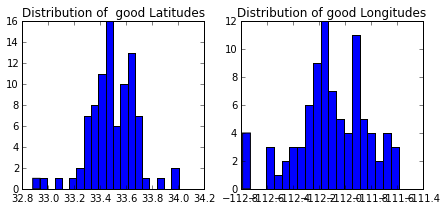

In [113]:
figsize(15, 3)
if len(goodList)>0:
    tornTupleG = coordGood.cluster.tolist()
    latsG      = coordGood.lati.tolist()
    lonsG      = coordGood.longi.tolist()
    #scalesG    = coordGood.scale.tolist()

    subplot(141)
    title("Distribution of  good Latitudes");
    hist(latsG, bins=20);

    subplot(142)
    title("Distribution of good Longitudes");
    hist(lonsG, bins=20);

    
if len(neutralList)>0:
    tornTupleN = coordNeutral.cluster.tolist()
    latsN      = coordNeutral.lati.tolist()
    lonsN      = coordNeutral.longi.tolist()
    #scalesN    = coordNeutral.scale.tolist()

    subplot(141)
    title("Distribution of  neutral Latitudes");
    hist(latsN, bins=20);

    subplot(142)
    title("Distribution of neutral Longitudes");
    hist(lonsN, bins=20);

Let us try now plot on a map using Basemaps. 

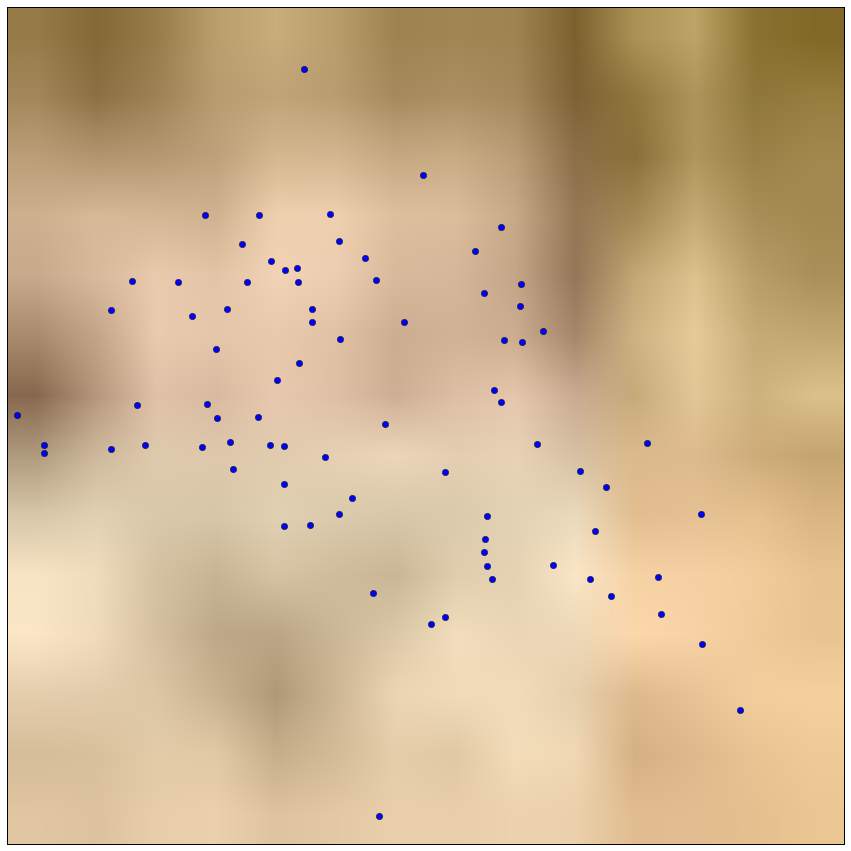

In [115]:
meanlat=df.latitude.mean()
meanlong=df.longitude.mean()

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt


# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=100000,height=100000,projection='lcc',
            resolution='h',lat_0=meanlat,lon_0=meanlong)
m.etopo()
m.drawcountries()
m.drawcoastlines() #(linewidth=0.5)
m.drawmapboundary()

figsize(15, 15)
if len(goodList)>0:
    for i in range(len(tornTupleG)):
        m.plot(lonsG[i], latsG[i], 'o', color="Blue", latlon=True)
    
if len(neutralList)>0:
    for i in range(len(tornTupleG)):
        m.plot(lonsG[i], latsG[i], 'o', color="Blue", latlon=True)
        
        
plt.show()

Resolution is terrible, so let us try something else, like Folium. 

In [116]:
from IPython.display import HTML
import folium
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 310px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))


In [120]:
meanlat=df.latitude.mean()
meanlong=df.longitude.mean()

map = folium.Map(width=600,height=600,location=[meanlat,meanlong], zoom_start=10)

if len(goodList)>0:
    for i in range(len(tornTupleG)):
        map.simple_marker([latsG[i], lonsG[i]], popup=str(tornTupleG[i])+' Reccomended',marker_color='green',marker_icon='ok-sign')

if len(neutralList)>0:
    for i in range(len(tornTupleG)):
        map.simple_marker([latsN[i], lonsN[i]], popup=str(tornTupleN[i])+' Neutral',marker_color='blue',marker_icon='ok-sign')    
        
inline_map(map)

In [49]:
i=210
hpom=df[df.cluster == i]
large = hpom.LQ.max()
topBus = hpom.name.ix[hpom.LQ == large].values[0]
topBusCat = hpom.categories.ix[(hpom.name == topBus) & (hpom.LQ == large)].values[0]
bus=hpom.categories.unique()
print i, topBusCat
print bus

210 Skate Parks
['Local Services' 'Dry Cleaning & Laundry' 'Optometrists'
 'Health & Medical' 'Beauty & Spas' 'Nail Salons' 'Home Services'
 'Real Estate' 'Apartments' 'Food' 'Grocery' 'Shipping Centers'
 'Printing Services' 'Notaries' 'Chiropractors' 'Fast Food' 'Sandwiches'
 'Restaurants' 'Sushi Bars' 'Japanese' 'Donuts' 'Web Design' 'Marketing'
 'Graphic Design' 'Professional Services' 'Nightlife' 'Irish' 'Bars'
 'Sports Bars' 'Libraries' 'Public Services & Government' 'Landscaping'
 'Veterinarians' 'Pets' 'Pizza' 'Automotive' 'Gas & Service Stations'
 'Plumbing' 'Active Life' 'Skate Parks' 'Swimming Pools' 'Parks'
 'Fitness & Instruction' 'Fashion' 'Shopping' 'Hair Salons'
 "Women's Clothing" 'Day Spas' 'Laser Hair Removal' 'Hair Removal'
 'Medical Spas' 'Real Estate Agents' 'Juice Bars & Smoothies' 'Gyms'
 'Trainers' 'Lounges']
